In [12]:
import photutils
import stpsf
import matplotlib.pylab as plt
from astropy.nddata import Cutout2D
from photutils.detection import IRAFStarFinder
from reproject import reproject_interp
import numpy as np
from astropy.io import fits
from astropy.stats import SigmaClip
from photutils.aperture import CircularAperture, ApertureStats
from astropy.wcs import WCS
import matplotlib.colors as colors
from scipy.stats import linregress

# Replacing saturated pixels in FULL with SUB640 using a transfer function:

$\rm Flux_{FULL} = \alpha \times \rm Flux_{SUB} + \beta$

In [13]:
jwstfilter = 'F150W'

file = f'../ESO484/NIRCam/finals/{jwstfilter}/{jwstfilter}_FULL_stage3.fits'

with fits.open(file) as psf:
    data = psf['SCI'].data
    header = psf['SCI'].header
    weight_map = psf['WHT'].data # Load weights instead of DQ

file_sub640 = f'../ESO484/NIRCam/finals/{jwstfilter}/{jwstfilter}_SUB640_stage3.fits'

with fits.open(file_sub640) as psf:
    data_replace = psf['SCI'].data
    header_replace = psf['SCI'].header

In [14]:
wcs = WCS(header)
wcs_replace = WCS(header_replace)

data_replace_reproj, _ = reproject_interp((data_replace, wcs_replace), wcs)

Set DATE-AVG to '2024-12-06T15:38:36.236' from MJD-AVG.
Set DATE-END to '2024-12-06T16:18:09.061' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    12.188957 from OBSGEO-[XYZ].
Set OBSGEO-H to 1679643598.088 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-10-30T22:12:54.475' from MJD-AVG.
Set DATE-END to '2024-10-30T22:19:32.153' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.630161 from OBSGEO-[XYZ].
Set OBSGEO-H to 1496517995.610 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


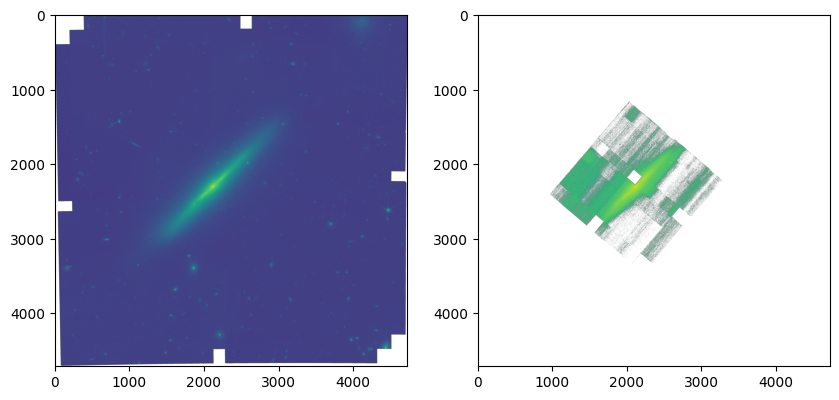

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data, norm=colors.LogNorm())
plt.subplot(1,2,2)
plt.imshow(data_replace_reproj, norm=colors.LogNorm())

In [16]:
mask_sat_full = np.isnan(data) 

# B. Mask low signal pixels in SUB (to avoid fitting noise)
# Adjust '0.1' to a reasonable surface brightness for your galaxy wings
mask_noise_sub = (data_replace_reproj < 0.1)

# C. The "Anchor" Mask: Good in FULL (Not saturated) AND Good in SUB
mask_anchor = (~mask_sat_full) & (~mask_noise_sub) & (~np.isnan(data_replace_reproj))

# 4. Calculate the Transfer Function (Linear Fit)
# Extract the pixel values from both images in the anchor region
pixels_full = data[mask_anchor]
pixels_sub = data_replace_reproj[mask_anchor]

print(f"Fitting flux relationship using {len(pixels_full)} pixels...")

# Perform linear regression: Full = slope * Sub + intercept
slope, intercept, r_value, p_value, std_err = linregress(pixels_sub, pixels_full)

print(f"  > Slope (Scale correction): {slope:.4f}")
print(f"  > Intercept (Background offset): {intercept:.4f}")
print(f"  > R-squared: {r_value**2:.4f}")

# 5. Apply Calibration to the Short Exposure
# We adjust the SUB image to match the FULL image's "reality"
data_sub_calibrated = (data_replace_reproj * slope) + intercept

# 6. Stitch the Images
# Create a copy of the FULL image
data_merged = data.copy()

# Identify where we NEED to replace: Where FULL is NaN (saturated) 
# AND where we have valid data in the calibrated SUB
replace_mask = np.isnan(data) & (~np.isnan(data_sub_calibrated))

# Replace
data_merged[replace_mask] = data_sub_calibrated[replace_mask]

Fitting flux relationship using 1112478 pixels...
  > Slope (Scale correction): 0.9888
  > Intercept (Background offset): 0.1551
  > R-squared: 0.9365


In [17]:
mask = (weight_map == 0)

bg_coordinates = [(3595, 3076), (2269, 325), (4098, 1163), (644, 3247)]

# 2. Define Apertures
radius = 3 
apertures = CircularAperture(bg_coordinates, r=radius)

# 3. Calculate Statistics (Median for Level, Std for Noise)
sigma_clip = SigmaClip(sigma=3.0)
phot_stats = ApertureStats(data_merged, apertures, mask=mask, sigma_clip=sigma_clip)

# Extract Median (Background Level) and Std (Background Noise)
four_medians = phot_stats.median 
four_stds = phot_stats.std  # <--- NEW: Get noise from the same regions

final_bg_value = np.nanmean(four_medians)
final_bg_noise = np.nanmean(four_stds) # Average the noise levels

print(f"Background Level: {final_bg_value:.4f}")
print(f"Background Noise (RMS): {final_bg_noise:.4f}")

# 4. Subtract Background
data_subtracted = data_merged - final_bg_value

# 5. Apply Cleaning Algorithm (S/N Thresholding)
# Create Signal-to-Noise Map
sn_map = data_subtracted / final_bg_noise

# Define Threshold (e.g., 3, 5, or 8 depending on how strict you want to be)
sn_threshold = 5.0 

# Apply Cleaning: Set pixels with low S/N to NaN
data_clean = np.where(sn_map < sn_threshold, np.nan, data_subtracted)

print(f"Cleaning complete. Kept pixels with S/N >= {sn_threshold}")

Background Level: 0.1832
Background Noise (RMS): 0.0083
Cleaning complete. Kept pixels with S/N >= 5.0


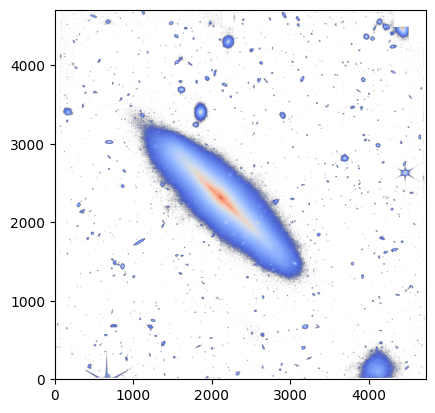

In [18]:
plt.imshow(data_clean, norm=colors.LogNorm(), origin = 'lower', cmap='coolwarm')

In [19]:
position = (2109, 2315)     
size_pixels = 2000         # size of subarray to use
cutout = Cutout2D(data_merged, position, size_pixels, wcs=wcs)
data_source = cutout.data
cutout_wcs = cutout.wcs

Text(0.5, 1.0, 'Cutout around a galaxy merger and a star')

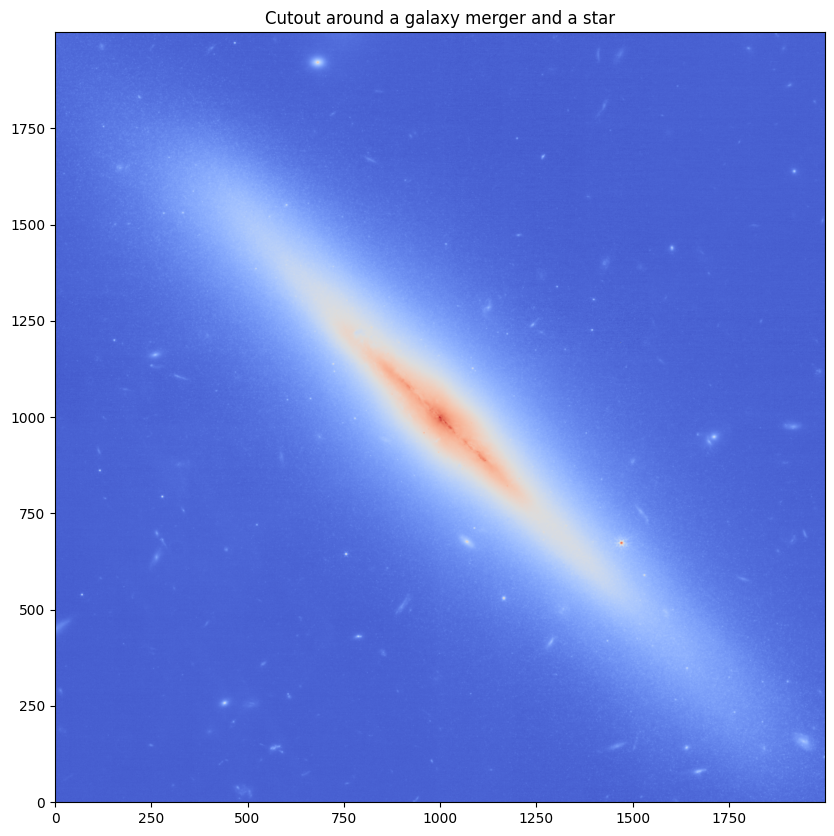

In [20]:
plt.figure(figsize = (10,10))
plt.imshow(data_source, norm = colors.LogNorm(), origin = 'lower', cmap='coolwarm')
plt.title("Cutout around a galaxy merger and a star")

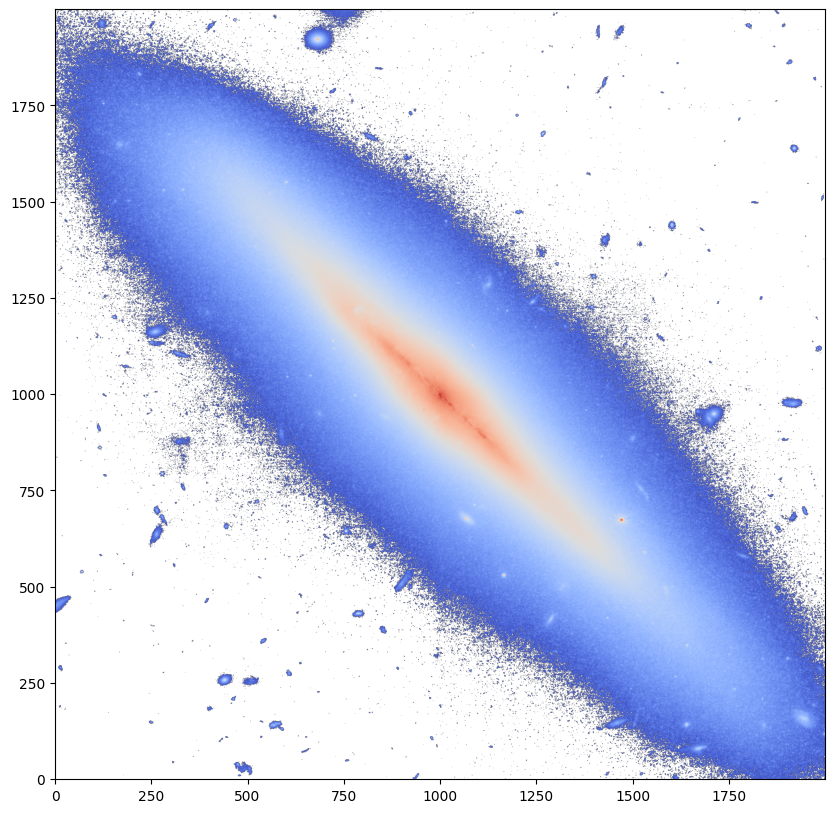

In [21]:
data_clean_for_image = Cutout2D(data_clean, position, size_pixels).data
plt.figure(figsize = (10,10))
plt.imshow(data_clean_for_image, norm = colors.LogNorm(), origin = 'lower', cmap='coolwarm')

In [36]:
from skimage import restoration

# PSF Calculation
inst = stpsf.setup_sim_to_match_file(file)
inst.options['jitter_sigma'] = 0.01
print(inst.detector_position)

# To avoid aliasing warning, calculate PSF with smaller FOV and pad to match image size
psf_fov = 1000
single_stpsf_nrc = inst.calc_psf(fov_pixels=psf_fov)
psf_kernel_temp = single_stpsf_nrc['DET_DIST'].data

# Pad the PSF to match the image size
pad_width = (size_pixels - psf_fov) // 2
psf_kernel = np.pad(psf_kernel_temp, pad_width, mode='constant', constant_values=0)

# Sharpen the PSF to increase contrast while preserving total flux
alpha = 3.0  # Adjust this value: >1 sharpens, <1 broadens
psf_kernel = psf_kernel ** alpha
psf_kernel = psf_kernel / np.sum(psf_kernel)  # Renormalize to preserve flux

# -----------------------------------------------------------------------
# 2. Prepare the Science Data (Safety Steps)
# -----------------------------------------------------------------------
# Richardson-Lucy (the deconvolution algorithm) strictly requires:
#  1. No NaNs
#  2. No Negative values (it assumes Poisson statistics)

data_clean = data_source.copy()

# A. Handle NaNs
data_clean = np.nan_to_num(data_clean, nan=0.0)

# B. Handle Negatives (Background noise)
# Since your data is background-subtracted, you likely have negative noise pixels.
# We add a "pedestal" (constant background) to make everything positive, 
# deconvolve, and then remove it later.
min_val = np.min(data_clean)
pedestal = 0
if min_val < 0:
    pedestal = np.abs(min_val) + 1.0  # Add a buffer to be safe
    print(f"Adding pedestal of {pedestal:.4f} to handle negative pixels.")
    data_clean += pedestal

Setting up sim to match ../ESO484/NIRCam/finals/F150W/F150W_FULL_stage3.fits

MAST OPD query around UTC: 2024-12-06T14:59:03.401
                        MJD: 60650.62434491898

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2024120603-NRCA1_FP6-1.fits
	Date (MJD):	 60650.0379
	Delta time:	 -0.5864 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2024121001-NRCA1_FP6-1.fits
	Date (MJD):	 60653.2681
	Delta time:	 2.6438 days
User requested choosing OPD time closest in time to 2024-12-06T14:59:03.401, which is R2024120603-NRCA1_FP6-1.fits, delta time -0.586 days
Importing and format-converting OPD from /home/joacoh/data/stpsf-data/MAST_JWST_WSS_OPDs/R2024120603-NRCA1_FP6-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA1_FP6)
Sensing inst model using apername NRCA1_FP6
Using sensing field point SI WFE model from file wss_target_phase_fp6.fits

Configured simulation instrument for:
    Instrument: NI

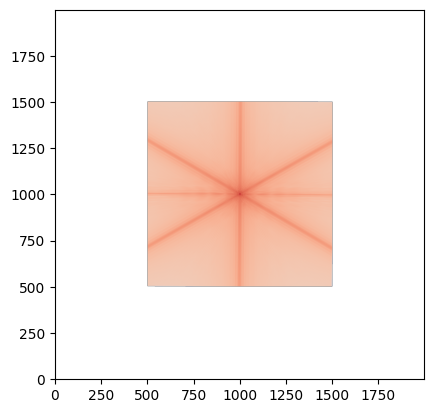

In [37]:
plt.imshow(psf_kernel, norm=colors.LogNorm(), origin='lower', cmap='coolwarm')

In [38]:
print(f"Sharpened PSF max: {np.max(psf_kernel):.6f}, sum: {np.sum(psf_kernel):.6f}")

Sharpened PSF max: 0.275650, sum: 1.000000


In [39]:
print("Running Richardson-Lucy Deconvolution...")

# num_iter: 
#   - Too low (e.g., 5): Image remains blurry.
#   - Too high (e.g., 50+): Introduces "speckle" noise and ringing artifacts.
#   - 15-20 is usually the sweet spot for JWST galaxies.
deconvolved_image = restoration.richardson_lucy(
    data_clean, 
    psf_kernel, 
    num_iter=3, 
    clip=False
)

if pedestal > 0:
    deconvolved_image -= pedestal

Running Richardson-Lucy Deconvolution...


In [269]:
# iter_steps = [0, 1, 2, 3, 4, 
#               5, 6, 8, 10, 12, 
#               14, 16, 18, 20, 25, 
#               30, 35, 40, 50, 60, 
#               70, 80, 90, 100, 150]

# # 2. Setup the plot
# fig, axes = plt.subplots(5, 5, figsize=(15, 15))
# axes = axes.flatten() # Flatten 5x5 grid to 1D array for easy looping

# print("Generating Deconvolution Mosaic...")

# # 3. Iterate through parameters and plot
# for i, n_iter in enumerate(iter_steps):
#     ax = axes[i]
    
#     if n_iter == 0:
#         # Step 0: The Original Clean Image
#         img_to_show = data_clean
#         title = "Original (0 iter)"
#     else:
#         # Run Deconvolution
#         # Note: Running this inside a loop is computationally expensive because 
#         # it restarts from scratch each time. For small galaxy cutouts, it's fine.
#         deconvolved = restoration.richardson_lucy(
#             data_clean, 
#             psf_kernel, 
#             num_iter=n_iter, 
#             clip=False
#         )
        
#         # Apply Pedestal Subtraction if needed
#         if pedestal > 0:
#             deconvolved -= pedestal
            
#         img_to_show = deconvolved
#         title = f"Iter: {n_iter}"

#     # 4. Plotting
#     # Use a consistent Log stretch or vmin/vmax so comparisons are fair
#     # (Assuming you have calculated vmin/vmax previously, otherwise use percentiles)
#     im = ax.imshow(img_to_show, origin='lower', cmap='coolwarm', norm=colors.LogNorm()) # Add vmin=... vmax=... here
    
#     ax.set_title(title, fontsize=10)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

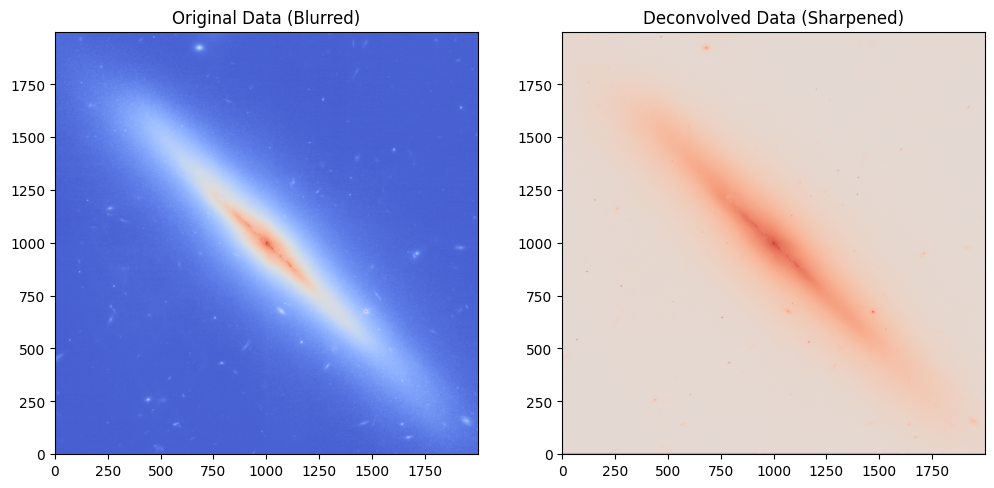

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(data_source, norm=colors.LogNorm(), origin='lower', cmap='coolwarm')
ax[0].set_title('Original Data (Blurred)')

ax[1].imshow(deconvolved_image, norm=colors.LogNorm(), origin='lower', cmap='coolwarm')
ax[1].set_title('Deconvolved Data (Sharpened)')

plt.show()

Text(0.5, 1.0, 'Deconvolved Data (Sharpened)')

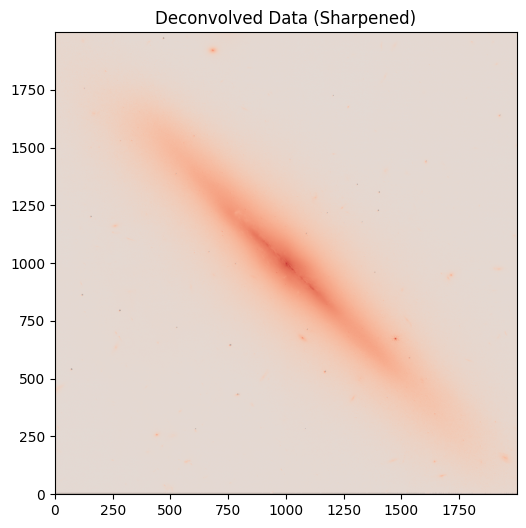

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.imshow(deconvolved_image, norm=colors.LogNorm(), origin='lower', cmap='coolwarm')
ax.set_title('Deconvolved Data (Sharpened)')

In [42]:
bg_coordinates = [(343, 817), (1483, 1195), (1144,109), (1534,1288)]

# 2. Define Apertures
radius = 3 
apertures = CircularAperture(bg_coordinates, r=radius)

# 3. Calculate Statistics (Median for Level, Std for Noise)
sigma_clip = SigmaClip(sigma=3.0)
phot_stats = ApertureStats(data_merged, apertures, mask=mask, sigma_clip=sigma_clip)

# Extract Median (Background Level) and Std (Background Noise)
four_medians = phot_stats.median 
four_stds = phot_stats.std  # <--- NEW: Get noise from the same regions

final_bg_value = np.nanmean(four_medians)
final_bg_noise = np.nanmean(four_stds) # Average the noise levels

print(f"Background Level: {final_bg_value:.4f}")
print(f"Background Noise (RMS): {final_bg_noise:.4f}")

Background Level: 0.1840
Background Noise (RMS): 0.0076


In [43]:
residual_subtracted = deconvolved_image - final_bg_value

# 5. Apply Cleaning Algorithm (S/N Thresholding)
# Create Signal-to-Noise Map
sn_map = residual_subtracted / final_bg_noise
# Define Threshold (e.g., 3, 5, or 8 depending on how strict you want to be)
sn_threshold = 5

# Apply Cleaning: Set pixels with low S/N to NaN
residual_clean = np.where(sn_map < sn_threshold, np.nan, residual_subtracted)

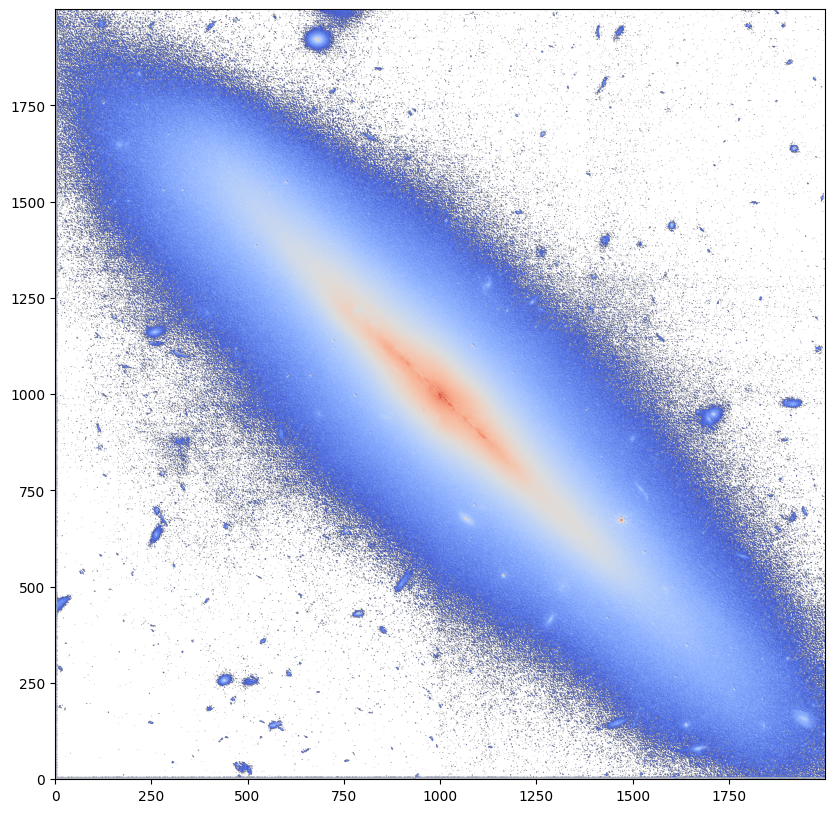

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(residual_clean, norm=colors.LogNorm(), origin = 'lower', cmap='coolwarm')
#plt.axvline(600)
#plt.axhline(600)

In [275]:
# Copy the original header
new_header = header.copy()

# Update WCS for the cutout
new_header.update(cutout_wcs.to_header())

# Add processing history
new_header['HISTORY'] = 'Pixel replacement: saturated FULL pixels replaced with calibrated SUB640 data'
# new_header['HISTORY'] = 'Background subtraction applied'
# new_header['HISTORY'] = 'S/N cleaning: pixels below 5 sigma set to NaN'
new_header['HISTORY'] = 'Richardson-Lucy deconvolution applied with 6 iterations'
new_header['HISTORY'] = f'PSF kernel sharpened with alpha={alpha} and normalized by sum to preserve flux'

# Note about flux scale
new_header['COMMENT'] = 'Deconvolved image with sharpened PSF; total flux preserved'

# Create HDU
hdu = fits.PrimaryHDU(data=deconvolved_image, header=new_header)

# Save the file
output_filename = f'../ESO484/NIRCam/finals/{jwstfilter}_deconvolved.fits'
hdu.writeto(output_filename, overwrite=True)
print(f"Deconvolved image saved to {output_filename}")

Deconvolved image saved to ../ESO484/NIRCam/finals/F430M_deconvolved.fits
